# Predição de Preço de Lares



In [1]:
# Modules

# General functionality and file manipulation
import os
from datetime import datetime

# Data Processing
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Confusion matrix
from sklearn.metrics import confusion_matrix

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

# Objective

É uma competição Kaagle no qual nosso objetivo será prever os preços das moradias utilizando redes neurais. Em especial, para cada "id" queremos prever o "SalePrice" na base de teste, baseado no modelo treinado na base de treino.

# Metric

Os envios são avaliados com base no erro quadrático médio (RMSE) entre o logaritmo do valor previsto e o logaritmo do preço de venda observado.

sum( ( log(y_i) - log(y^hat_i) )^2 )_{i=0}^{n}

# Data Reading and Wrangling

In [2]:
train = pd.read_csv('data/train.csv')
display(train.head())
print(f"Dim:\n{train.shape}")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dim:
(1460, 81)


Useless columns that have much NA's. We will drop them.

Also, we will be dropping 'id'.

In [3]:
display(train.isna().mean()[train.isna().mean() > 0.3])

Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [4]:
useless_cols = train.isna().mean()[train.isna().mean() > 0.3].index.tolist()
useless_cols.append('Id')
train.drop(columns=useless_cols, inplace=True)

# EDA

In [5]:
df = train

## Studying SalePrice

In [6]:
print(f"NA Count: {df['SalePrice'].isna().mean()}")

NA Count: 0.0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
/home/adriel_martins/Documents/Adriel_ET645/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

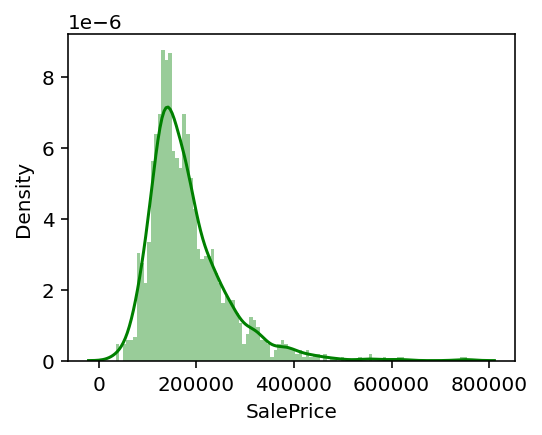

In [7]:
print(df['SalePrice'].describe())
plt.figure(figsize=(4, 3))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})

## Numerical Explanatory Variables

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

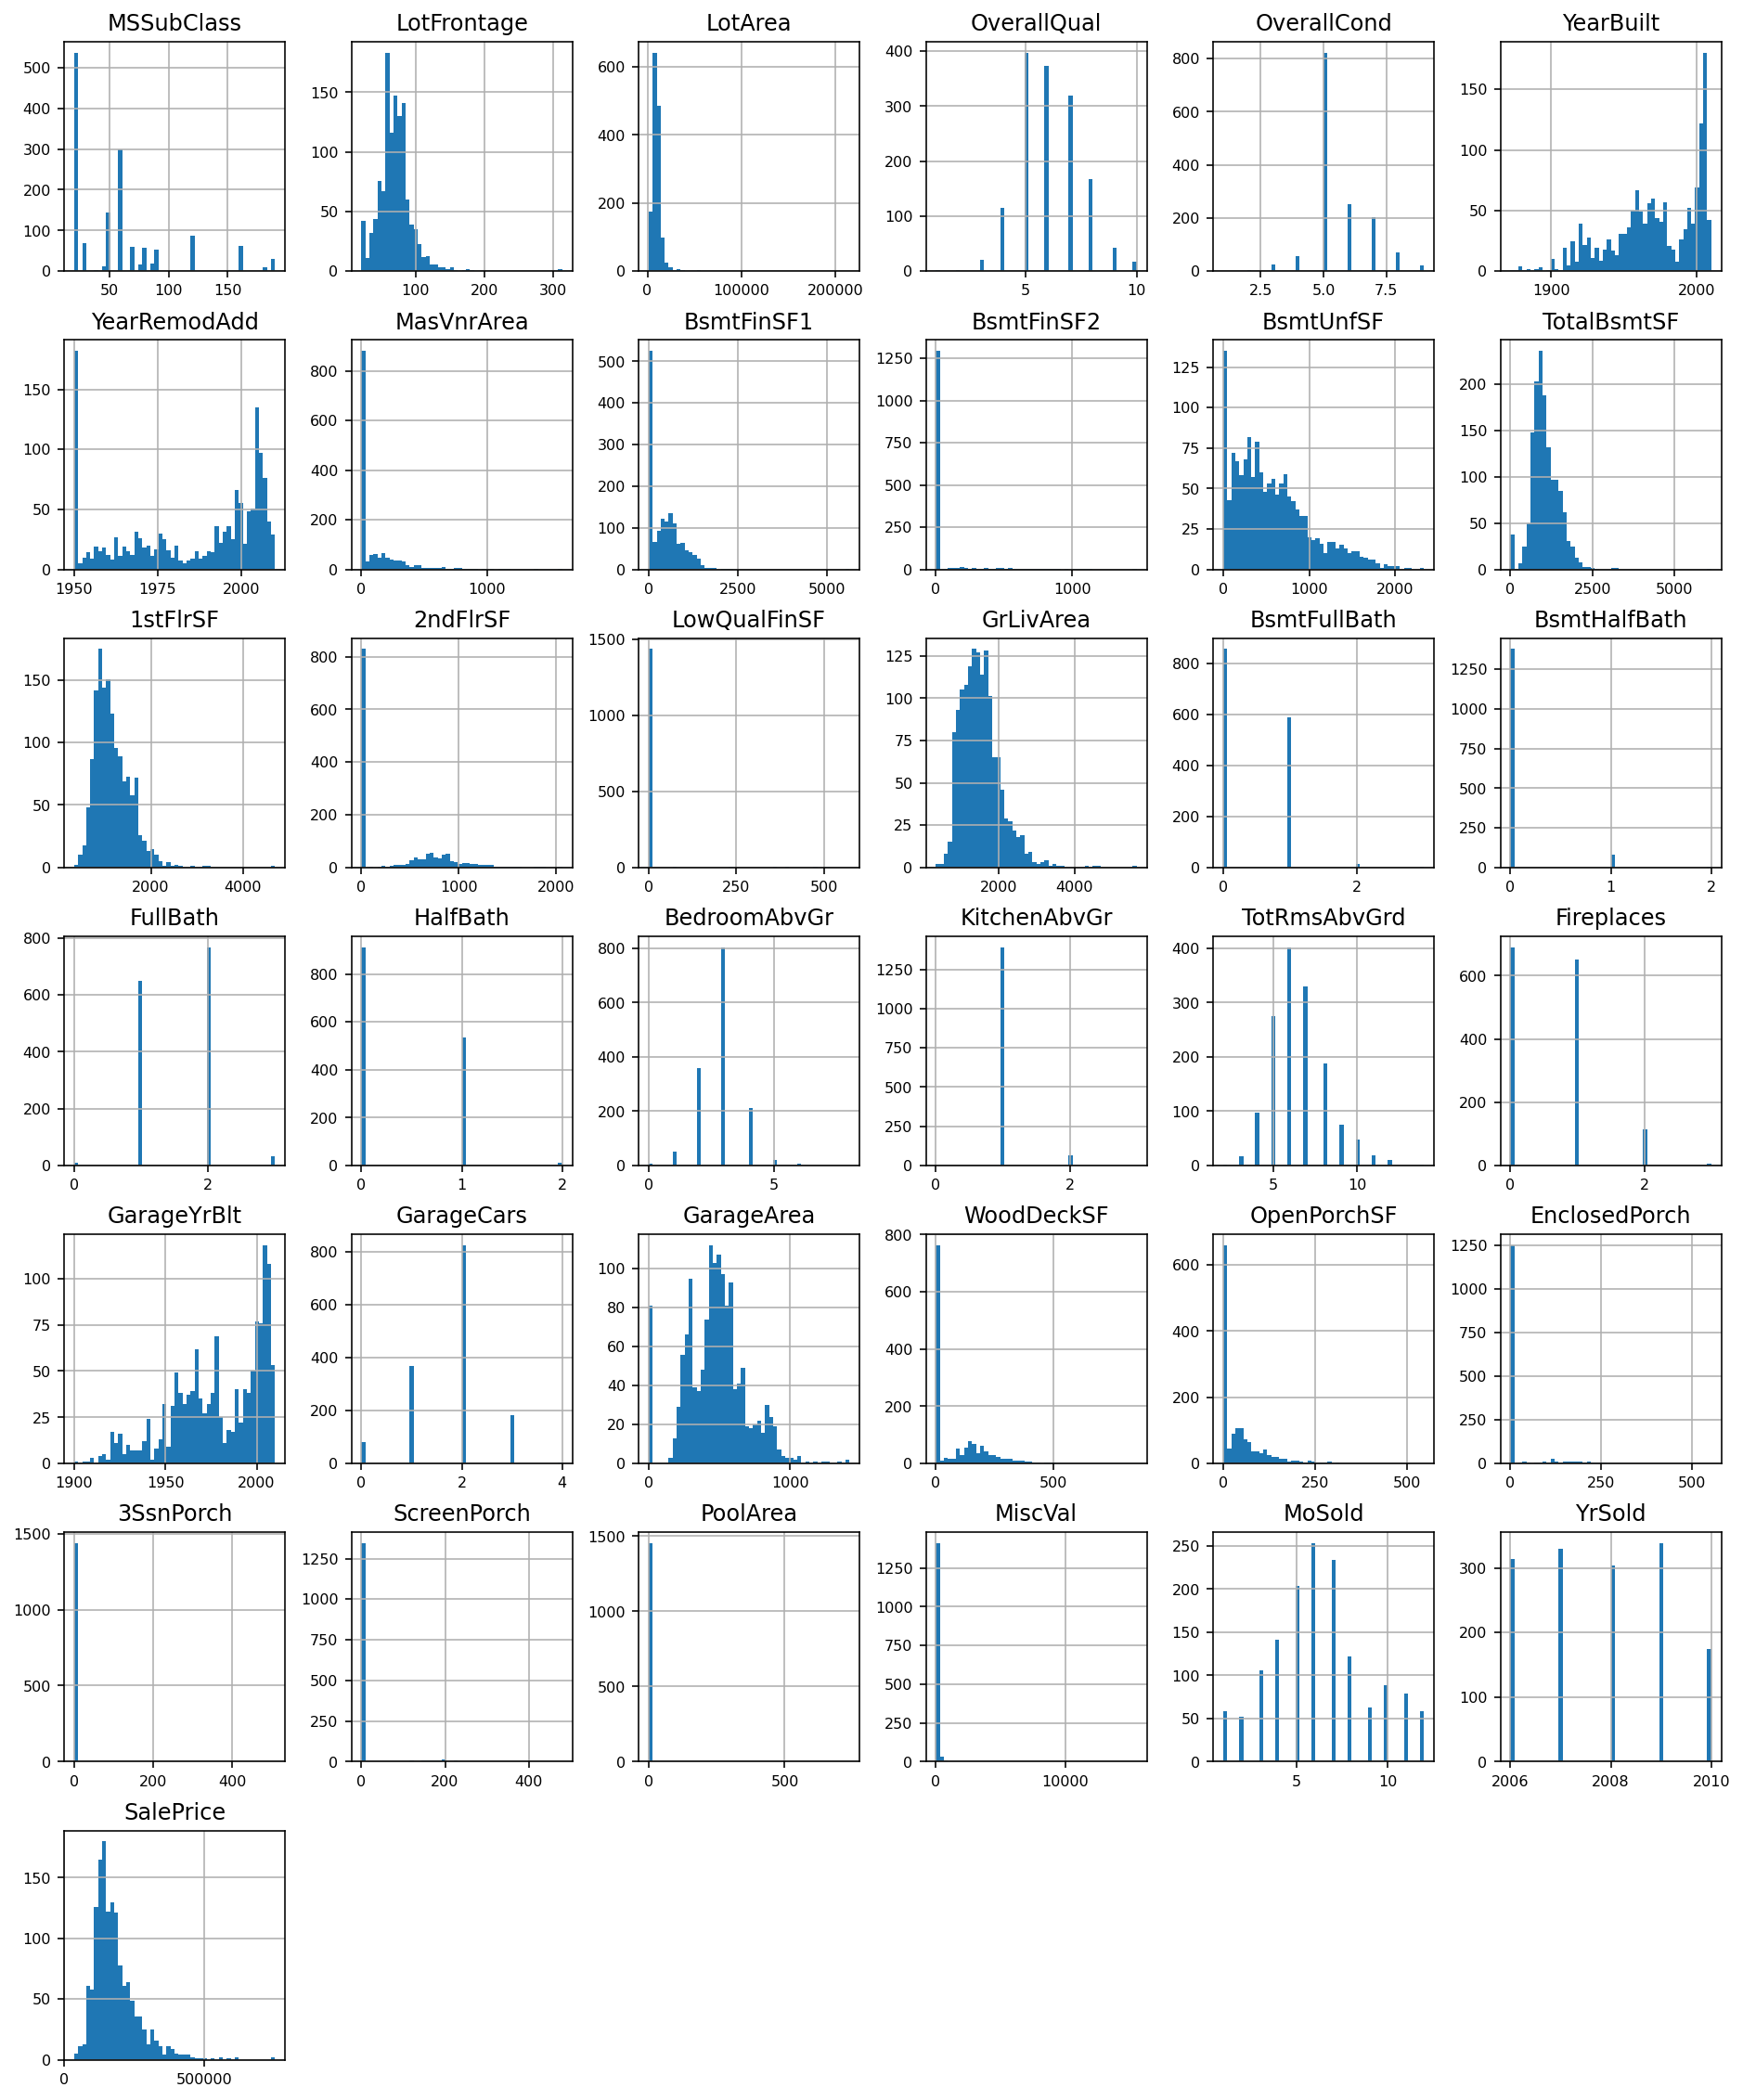

In [8]:
df.select_dtypes(include = ['float64', 'int64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Linear Correlation of Numerical Variables with SalePrice

In [9]:
df_num_corr = df.select_dtypes(include = ['float64', 'int64']).corr()['SalePrice'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 10 strongly correlated values with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


### Non Linear Correlation with SalePrice

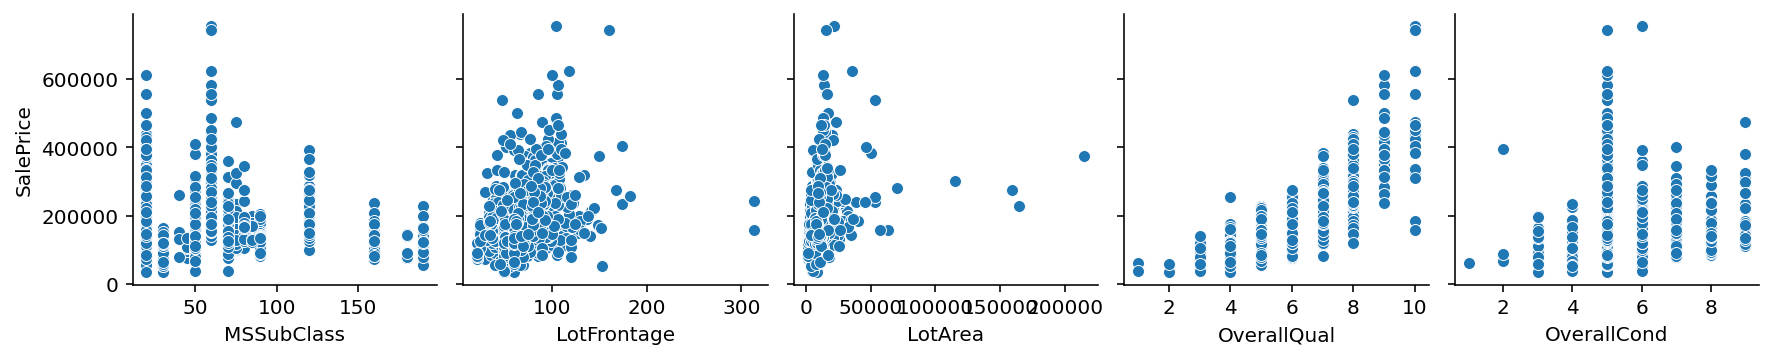

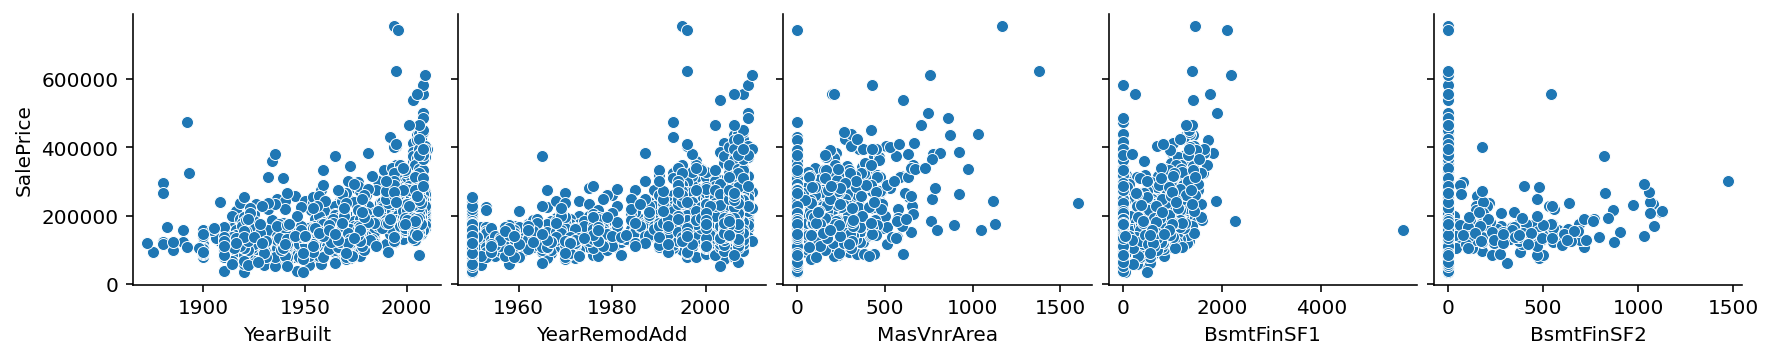

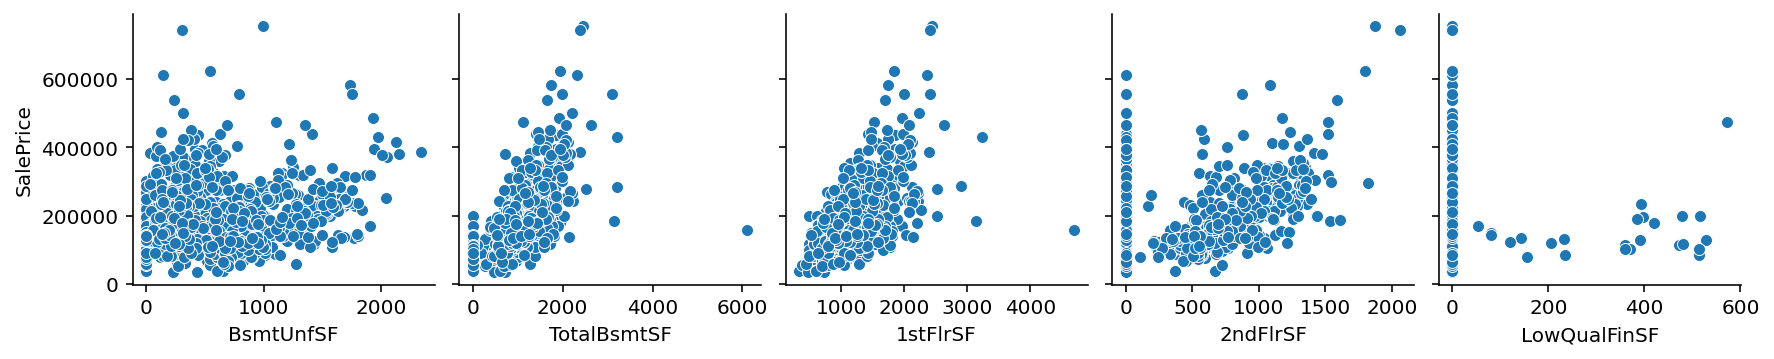

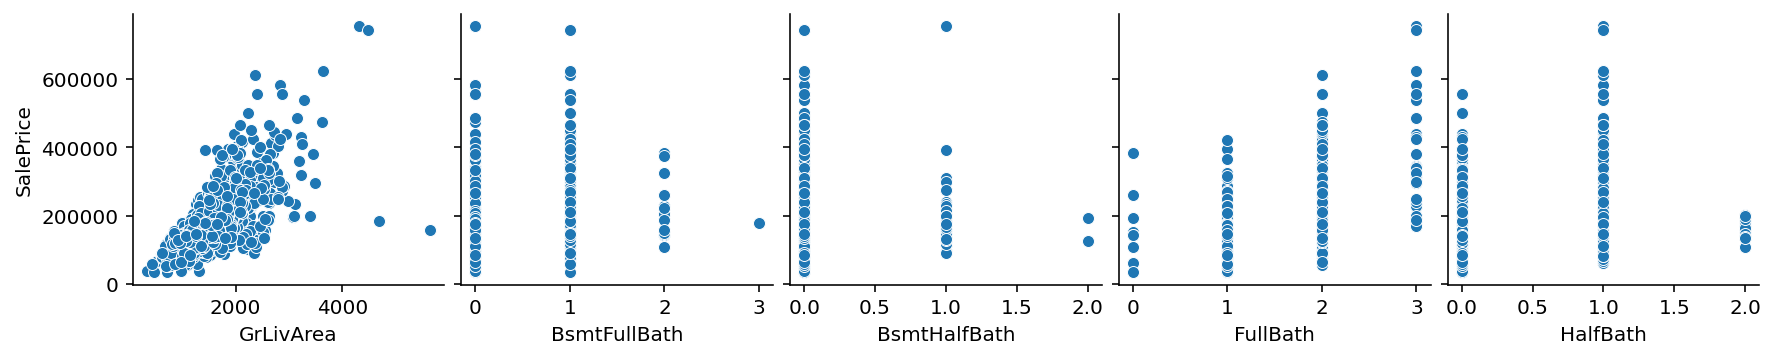

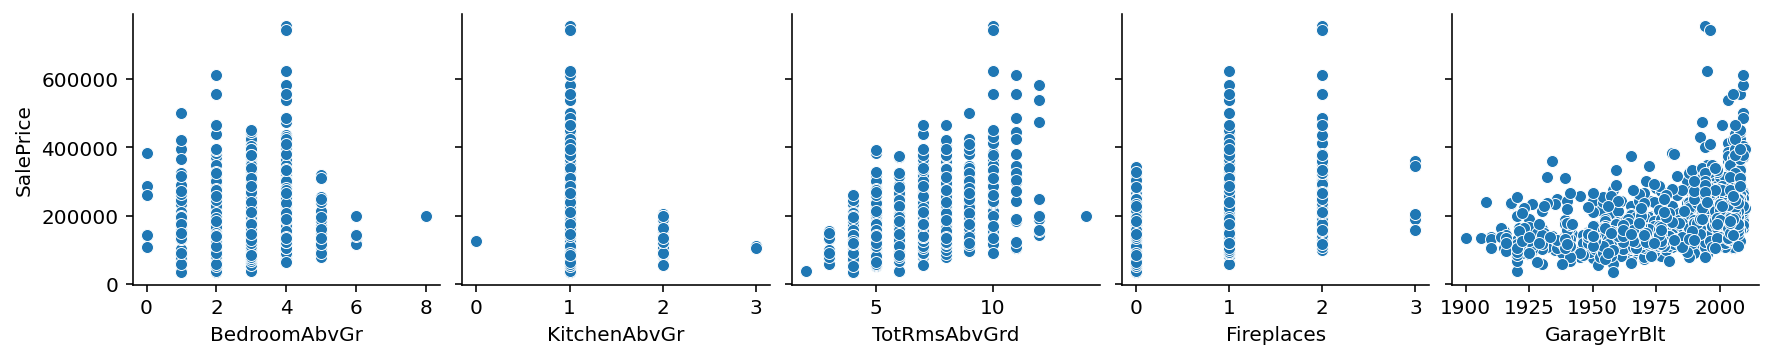

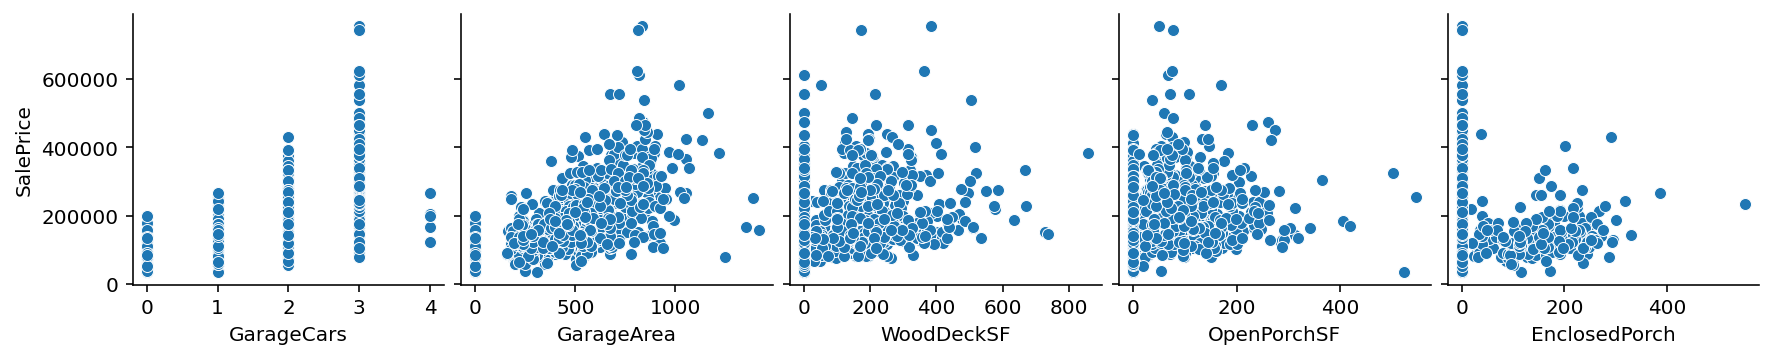

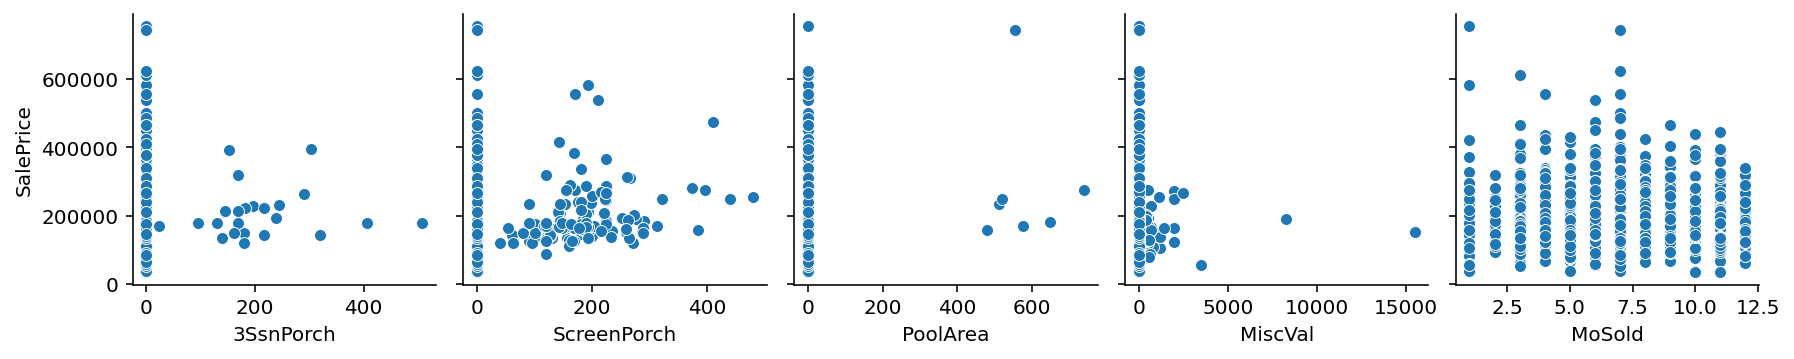

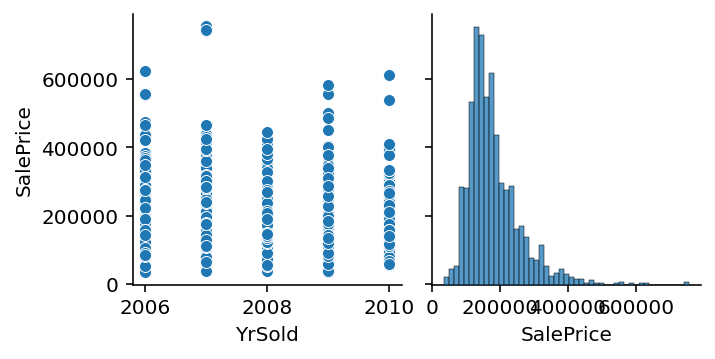

In [10]:
for i in range(0, len(df.select_dtypes(include = ['float64', 'int64']).columns), 5):
    sns.pairplot(data=df.select_dtypes(include = ['float64', 'int64']),
                x_vars=df.select_dtypes(include = ['float64', 'int64']).columns[i:i+5],
                y_vars=['SalePrice'])

### Correlations between all variables

<AxesSubplot:>

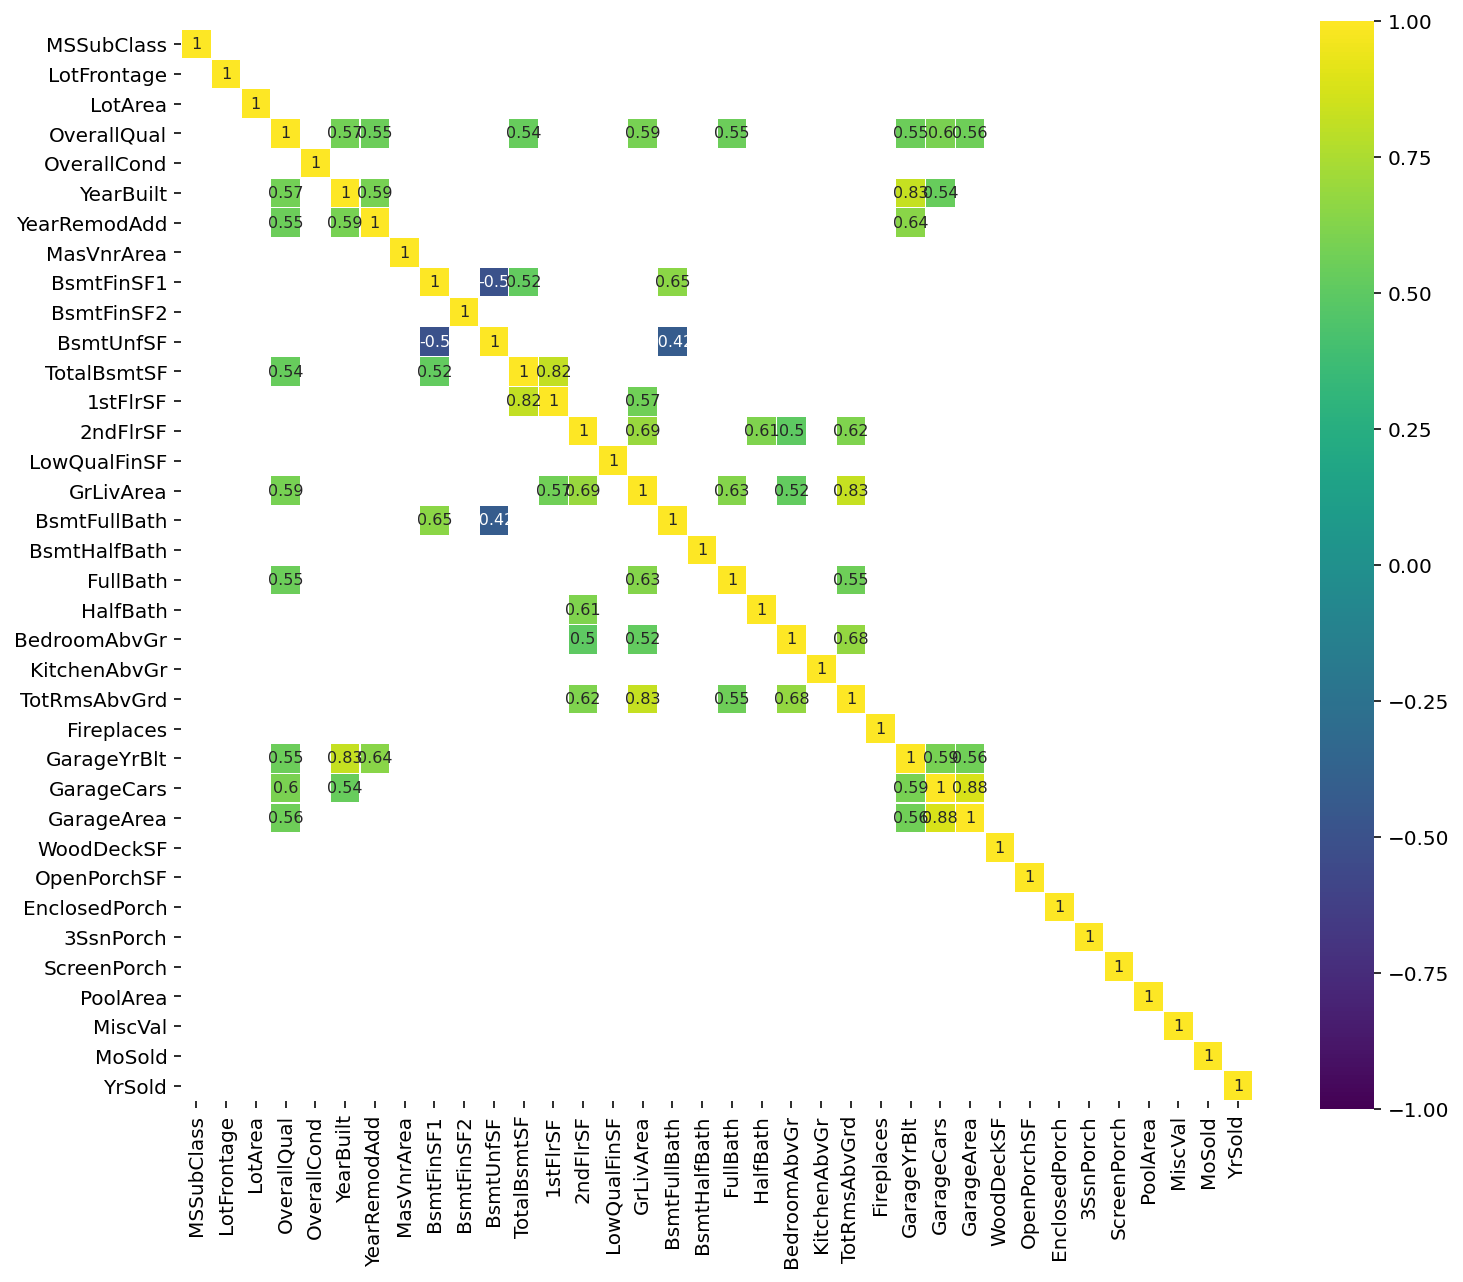

In [11]:
corr = df.select_dtypes(include = ['float64', 'int64']).drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### Analyzing the strong linear correlations.

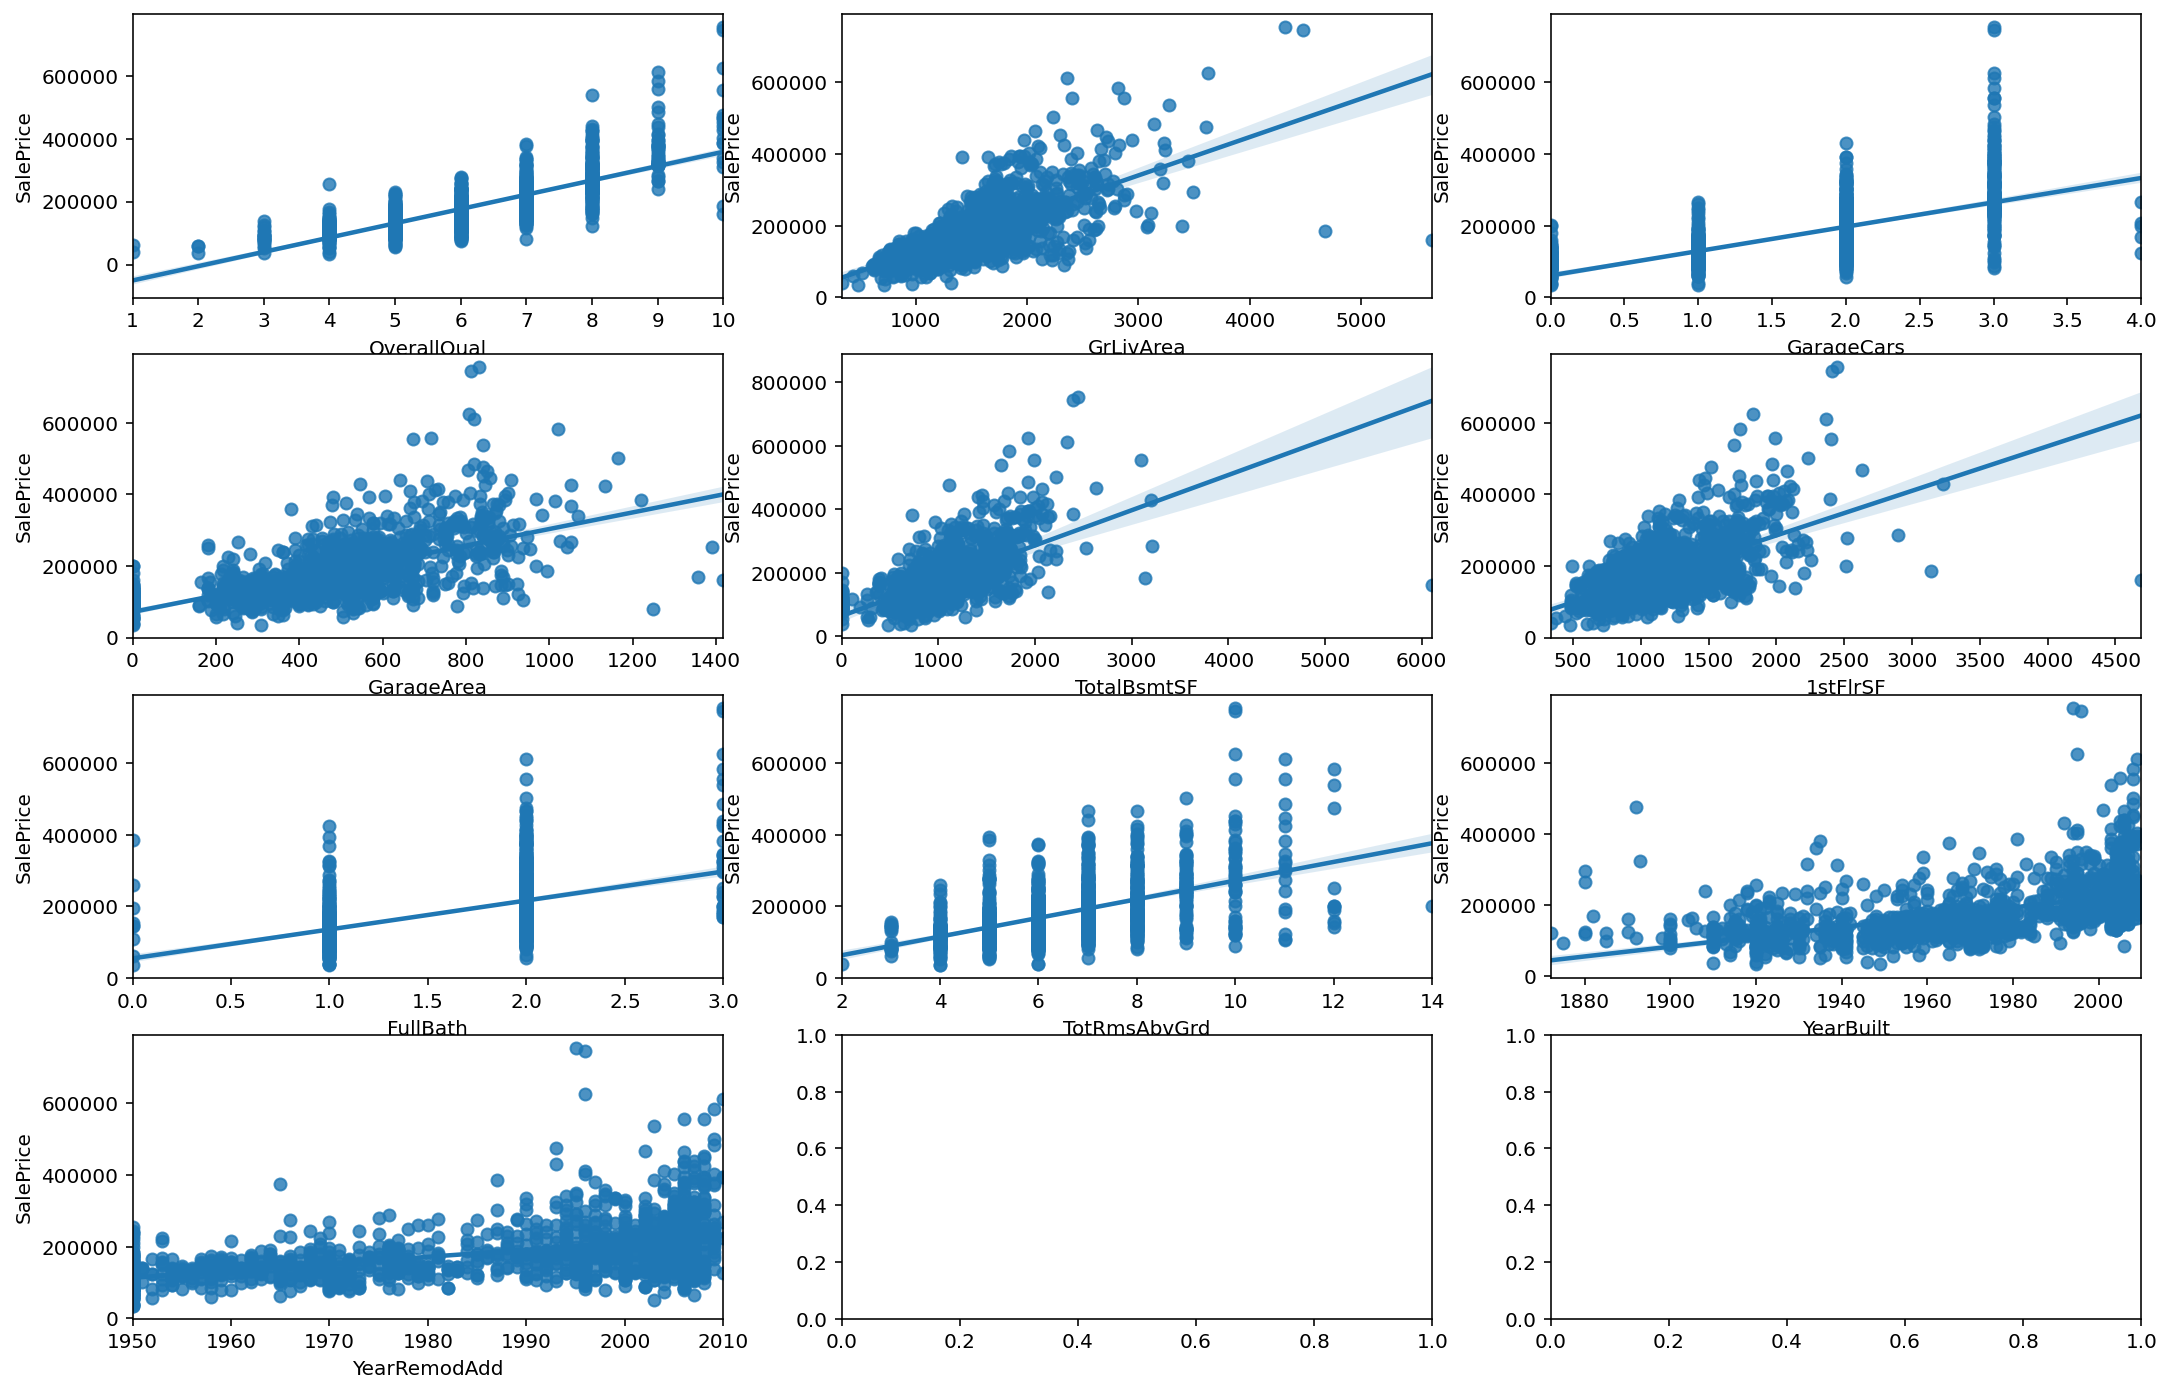

In [12]:
features_to_analyse = golden_features_list.index.to_list()
features_to_analyse.append('SalePrice')
features_to_analyse = np.array(features_to_analyse)

fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='SalePrice', data=df[features_to_analyse], ax=ax)

# Data Wrangling

## Preprocess

In [13]:
def preprocess(df, transformers:dict={}):
    """
    Preprocess the dataframe to better use in the model.

    Args:
        df (pd.DataFrame)
        transformers (dict, optional): Dictionary of transformers. Defaults to {}.

    Returns:
        [pd.DataFrame]
        [dict]: Dictionary of transformers used. 
    """
    
    df_wrangling = df.copy()

    # One Hot Enconding
    categorical_variables = df_wrangling.select_dtypes(exclude = ['float64', 'int64'])
    try:
        enc = transformers['encoder']
    except:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(categorical_variables)
    
    df1 = enc.transform(categorical_variables).toarray()
    df1 = pd.DataFrame(df1, columns=enc.get_feature_names(categorical_variables.columns.tolist()))
    df2 = df_wrangling.drop(columns=categorical_variables.columns)
    df_wrangling = pd.concat([df1, df2], axis=1)

    # Scaling 
    try:
        scaler = transformers['scaler']
        if not 'label' in df_wrangling.columns:
            df_wrangling['label'] = np.repeat(0, len(df_wrangling))
    except:
        scaler = MinMaxScaler()
        scaler.fit(df_wrangling)

    df_wrangling = pd.DataFrame(scaler.transform(df_wrangling),
                                columns=df_wrangling.columns)
    if ((df_wrangling['label'] == 0).mean() == 1):
        df_wrangling.drop(columns='label', inplace=True)

    # Dropping useless columns
    try:
        useless_cols = transformers['cols_to_drop']
    except:
        useless_cols = df_wrangling.isna().mean()[df_wrangling.isna().mean() > 0.3].index.tolist()
        useless_cols.append('Id')

    df_wrangling.drop(columns=useless_cols, inplace=True)

    # Dropping NA's
    df_wrangling.dropna(inplace=True)

    return df_wrangling, {'scaler': scaler,
                          'encoder': enc,
                          'cols_to_drop': useless_cols}

## Dataloader and Transformations

In [14]:
class DataRow(Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        self.predict_data = not ('label' in df.columns.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx]

        if self.predict_data:
            label = -1
            features = row.to_numpy()
        else:
            label = row['label']
            features = row.drop(labels='label').to_numpy()
            
        row = {'label': label, 'features': features}
        
        if self.transform:
            row = self.transform(row)
        
        return row 

In [15]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        label, features = sample['label'], sample['features']

        # If data is to be predicted.
        if label == -1:
            return {'label': label,
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

        return {'label': torch.from_numpy(np.array(label)).type(torch.FloatTensor),
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

In [16]:
def make_dataloader(df, batch_size):
    data = DataRow(df=df,
                   transform=transforms.Compose([ToTensor()]))
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader

In [17]:
batch_size = 128
label_name = 'SalePrice'

df_train = pd.read_csv('data/train.csv').rename(columns={label_name: 'label'})
df_train, train_transformers = preprocess(df_train)

X_train, X_validation, y_train, y_validation = train_test_split(df_train[[col for col in df_train.columns if col != 'label']],
                                                                df_train['label'],
                                                                test_size = 0.1)

X_train['label'] = y_train
X_validation['label'] = y_validation

df_train = X_train
df_validation = X_validation

df_test, transformers = preprocess(pd.read_csv('data/test.csv'),
                                  transformers=train_transformers)

dataloader = {}
names = ['train', 'validation', 'test']
for idx, df in enumerate([df_train, df_validation, df_test]):
    dataloader.update({names[idx]: make_dataloader(df, batch_size)})

In [18]:
pd.read_csv('data/test.csv')[pd.read_csv('data/train.csv').drop(columns='SalePrice').columns.tolist()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [19]:
for data in iter(dataloader['test']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([-0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485, -0.0485,
        -0.0485, -0.0485, -0.0

In [20]:
for data in iter(dataloader['train']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([0.2168, 0.3959, 0.1439, 0.2640, 0.2904, 0.1821, 0.1293, 0.4709, 0.1210,
        0.5586, 0.2140, 0.2140, 0.1653, 0.1321, 0.1585, 0.0946, 0.2182, 0.1372,
        0.1953, 0.2084, 0.1348, 0.2264, 0.1973, 0.2348, 0.1078, 0.2097, 0.1515,
        0.2876, 0.1112, 0.1496, 0.1390, 0.1244, 0.2237, 0.0465, 0.1418, 0.4029,
        0.1348, 0.2112, 0.1807, 0.1515, 0.2202, 0.2709, 0.1487, 0.2168, 0.1987,
        0.1279, 0.1328, 0.1571, 0.4862, 0.1821, 0.2112, 0.1932, 0.1300, 0.4015,
        0.0855, 0.1460, 0.0446, 0.1425, 0.3890, 0.2300, 0.4142, 0.1529, 0.3890,
        0.2251, 0.1737, 0.1809, 0.2154, 0.0904, 0.2154, 0.2362, 0.5098, 0.2709,
        0.1965, 0.3897, 0.1376, 0.5626, 0.2168, 0.1959, 0.2196, 0.1946, 0.2036,
        0.1178, 0.1154, 0.1168, 0.0973, 0.1112, 0.3024, 0.1626, 0.1444, 0.1182,
        0.1251, 0.1279, 0.1487, 0.1425, 0.1529, 0.1279, 0.2807, 0.1265, 0.2000,
        0.0411, 0.1348, 0.2069, 0.2376, 0.1515, 0.2591, 0.2014, 0.1321, 0.1529,
        0.2119, 0.0973, 0.1390

# Modelling

We will use the "linear regression" approach. We will model a neural net. that have no deep layer. There will only be input layer and output layer.

## Neural Network Architecture

In [21]:
class LinearRegression(nn.Module):
    def __init__(self, n_input, n_outputs):
        super().__init__()
        # Input layer with Output layer
        self.fc1 = nn.Linear(n_input, n_outputs)
        
    def forward(self, x):
        x = self.fc1(x).flatten()
        return x

## Trainning the model

In [22]:
def train_model(model, dataloader,
                criterion, optimizer,
                n_epoch=10, path_to_save='model.pt', 
                print_every=None):
    """
    Train our Neural Network with data and return the trained model,
    the plot diagnostics and also save the model in the path_to_save.
    
    Args:
    dataloader (dict): contains train dataloader and validation dataloader.
    path_to_save (str): path to save the model parameters in the .pt format.
    
    Returns:
    model: model trained with model.eval() = True.
    """
    # Checking if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cpu_or_gpu = ('GPU' if torch.cuda.is_available() else 'CPU')
    print(f"Running training on {cpu_or_gpu}")
    model = model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to +infinity

    train_losses = []
    valid_losses = []
    
    if print_every is None:
        print_every = int(n_epoch * 0.1) + 1
        
    for epoch in range(1, n_epoch + 1):
        
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # prep model for training
        model.train() 
        print('\n Training Loss...')
        turn = 0
        for data in dataloader['train']:

            x_train = data['features'].to(device)
            y_train = data['label'].to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_train) 
            # calculate the loss
            loss = criterion(output, y_train)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()
            
            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss}')


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        print("\n Validation Loss...")
        turn = 0
        for data in dataloader['validation']:
            x_validation = data['features'].to(device)
            y_validation = data['label'].to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_validation) # log_ps
            # calculate the loss
            loss = criterion(output, y_validation) 
            # update running validation loss 
            valid_loss += loss.item()

            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss} \n')

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(dataloader['train'])
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(dataloader['validation'])
        valid_losses.append(valid_loss)

        print(f"""
            Epoch: {epoch}
            \tTraining Loss: {round(train_loss, 6)}
            \tValidation Loss: {round(valid_loss, 6)}
            """)

        # save model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased \
                ({round(valid_loss_min,6)} --> {round(valid_loss,6)}).\
                    Saving model ...')
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss
    
    # Plotting train and validation losses.
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    
    return model

Running training on GPU

 Training Loss...

 Validation Loss...

            Epoch: 1
            	Training Loss: 0.02948
            	Validation Loss: 0.018542
            
Validation loss decreased                 (inf --> 0.018542).                    Saving model ...

 Training Loss...

 Validation Loss...

            Epoch: 2
            	Training Loss: 0.023885
            	Validation Loss: 0.016091
            
Validation loss decreased                 (0.018542 --> 0.016091).                    Saving model ...

 Training Loss...

 Validation Loss...

            Epoch: 3
            	Training Loss: 0.020917
            	Validation Loss: 0.014348
            
Validation loss decreased                 (0.016091 --> 0.014348).                    Saving model ...

 Training Loss...

 Validation Loss...

            Epoch: 4
            	Training Loss: 0.01876
            	Validation Loss: 0.013469
            
Validation loss decreased                 (0.014348 --> 0.013469).    

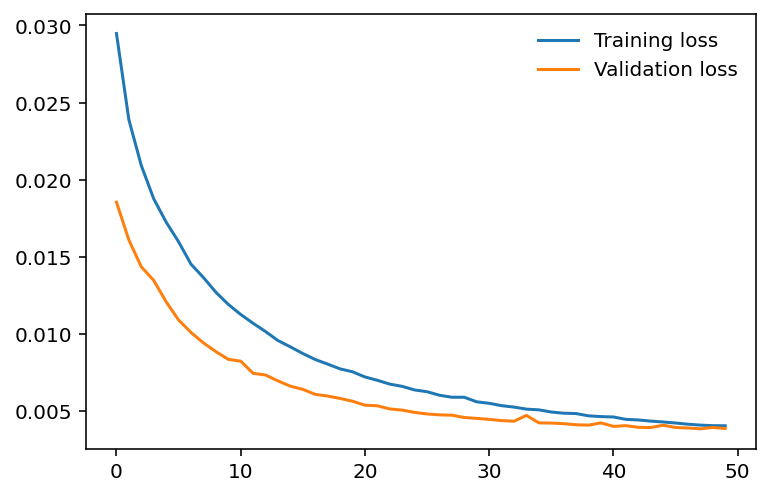

In [23]:
for data in iter(dataloader['train']):
    n_features = data['features'].shape[1]
    break
model = LinearRegression(n_input=n_features, n_outputs=1)

criterion = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model = train_model(model=model, n_epoch = 50,
                    dataloader=dataloader,criterion=criterion,
                    optimizer=optimizer, print_every=50)

In [24]:
# Reading the model parameters saved
for data in iter(dataloader['train']):
    n_features = data['features'].shape[1]
    break
mdel = LinearRegression(n_input=n_features, n_outputs=1)
model.load_state_dict(torch.load('model.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LinearRegression(
  (fc1): Linear(in_features=304, out_features=1, bias=True)
)

## Predict new dataset

In [83]:
def get_train_scaler():
    scaler_train = MinMaxScaler()
    df_train = pd.read_csv('data/train.csv').rename(columns={'SalePrice': 'label'})
    y_train = df_train['label'].values.copy()
    y_train.shape = (-1, 1)
    scaler_train.fit(y_train)
    return scaler_train

def scale_inverse(y_predicted, scaler):
    y_predicted = y_predicted.cpu().numpy()
    y_predicted.shape = (-1,1)
    return scaler_train.inverse_transform(y_predicted).flatten()

def predict(model, feat, scaler_train=get_train_scaler()):
    model.eval() # prepare model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # To speed up calculations, forget the gradients, etc.
    with torch.no_grad():
        x = data['features'].to(device)
        output = model(x)
        output = scale_inverse(output, scaler_train)
        return output

# Reading the model parameters saved
for data in iter(dataloader['test']):
    new_features = data['features']
    print(new_features.shape)

    y_predicted = predict(model, new_features)
    print(y_predicted.shape)
    print(y_predicted)
    break

torch.Size([128, 304])
(128,)
[218681.77  108943.73  112456.63  242009.34  440042.4   183003.48
 211521.39  164882.5   185274.6   223463.89  114621.85  232953.11
 167316.86  179684.67  172143.3   209404.3   131107.73  150283.28
 275243.72  241282.67   57081.098 128752.86  256107.56  198935.77
 203163.11  119404.766  50702.13  403725.47  342445.62  132432.56
 135732.45  133703.45  143775.6   210749.31  217312.98  165782.06
 410531.4   222093.62  119607.375 389282.5   153504.02  169336.95
 144762.61  156142.05  130244.61  186096.58  138812.95   81220.016
 392291.84   55079.73  123160.95  413088.66  158078.08  115489.484
 237856.38  301603.25  159806.39  163125.94  198886.64  174469.62
 162835.31  389335.8   206351.75   58858.754 225625.52   95286.23
 129103.79  203844.2   289328.28  113851.23  162983.53  315197.94
 193946.67  126980.15   96964.    134655.02  119571.36  414858.53
 166984.56  244153.1   123625.45  182212.81  217630.77  350254.28
 278733.75  163630.27  146057.34  243698.06 

/home/adriel_martins/Documents/Adriel_ET645/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

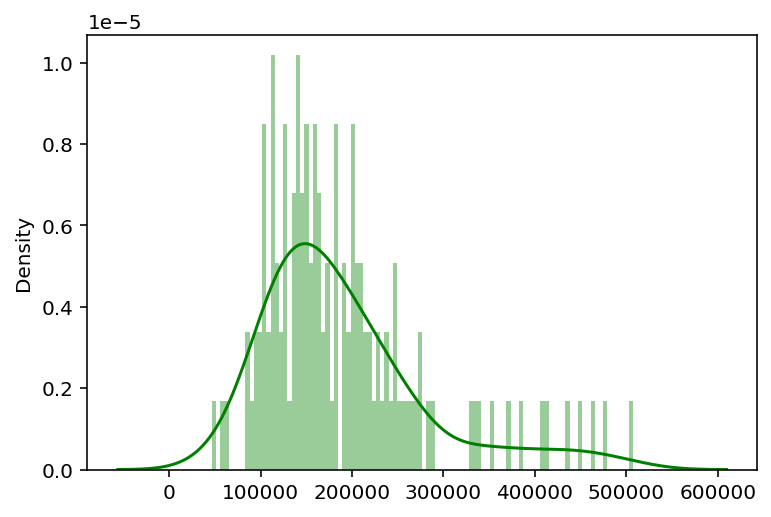

In [76]:
sns.distplot(y_final, color='g', bins=100, hist_kws={'alpha': 0.4})